In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [100]:
# MNIST dataset

from torchvision import datasets, transforms
import torchvision

# Split MNIST into train, validation, and test sets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transforms.ToTensor())

# Split train_data into train and validation sets
val_data = torch.utils.data.Subset(train_data, range(50000, 60000))

# Reduce the size of the training set to 5,000
train_data = torch.utils.data.Subset(train_data, range(0, 5000))


In [101]:
# Create data loaders
batch_size = 1

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [102]:
img, target = next(iter(train_loader))
print(img.shape)
print(target.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1])


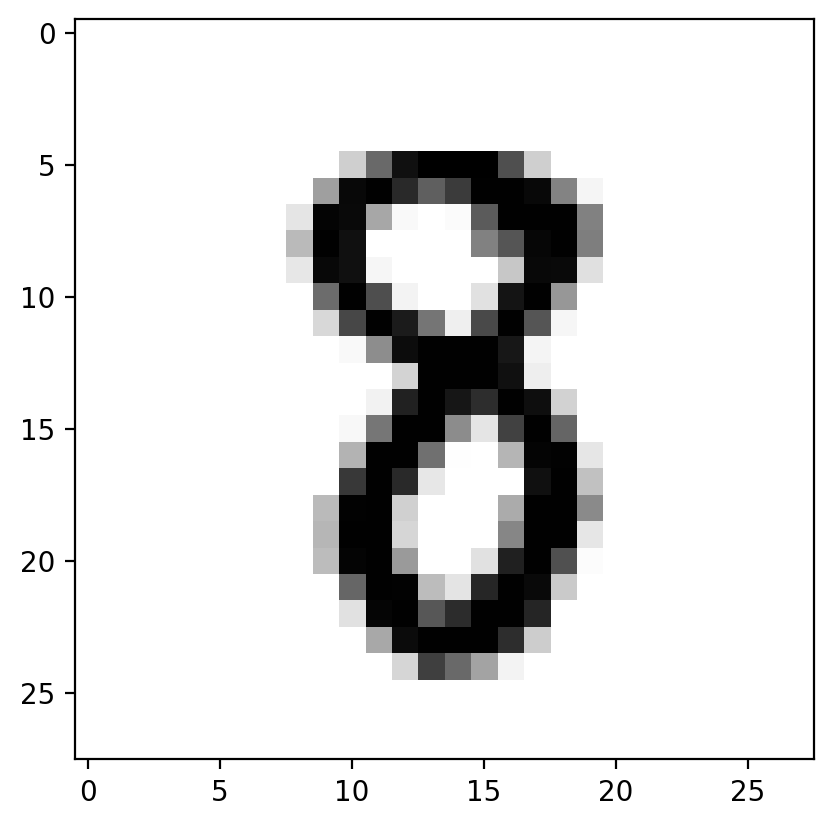

In [103]:
plt.imshow(img[0].numpy().squeeze(), cmap='gray_r');

In [104]:
target

tensor([8])

In [105]:
# Store the labels and Images in TensorBoard

from torch.utils.tensorboard import SummaryWriter

# Default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/mnist_experiment_1')

# Add images to tensorboard in the form of a grid in batches of 64
dataiter = iter(DataLoader(train_data, batch_size=64, shuffle=True))

# Add a slider in tensorboard to iterate through the batches
for i in range(10):
    images, labels = next(dataiter)
    images = torchvision.utils.make_grid(images)
    # Add images with labels to tensorboard
    writer.add_image(f'mnist_images_{i}', images, global_step=i)

In [106]:
# Define model for 10-class MNIST classification

class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        z1 = self.fc1(x)
        a1 = F.relu(z1)
        z2 = self.fc2(a1)
        a2 = F.relu(z2)
        z3 = self.fc3(a2) # logits
        return z3

In [107]:
model = MNISTClassifier()

# Get model summary
from torchsummary import summary
summary(model, (1, 784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]          50,240
            Linear-2                [-1, 1, 32]           2,080
            Linear-3                [-1, 1, 10]             330
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.20
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


torch.Size([1, 784])
tensor([[ 0.0734,  0.2403,  0.1308, -0.1688,  0.0012, -0.0060, -0.0431, -0.0258,
          0.0672,  0.0365]], grad_fn=<AddmmBackward0>)
tensor([[0.1038, 0.1227, 0.1099, 0.0815, 0.0966, 0.0959, 0.0924, 0.0940, 0.1032,
         0.1001]], grad_fn=<SoftmaxBackward0>)


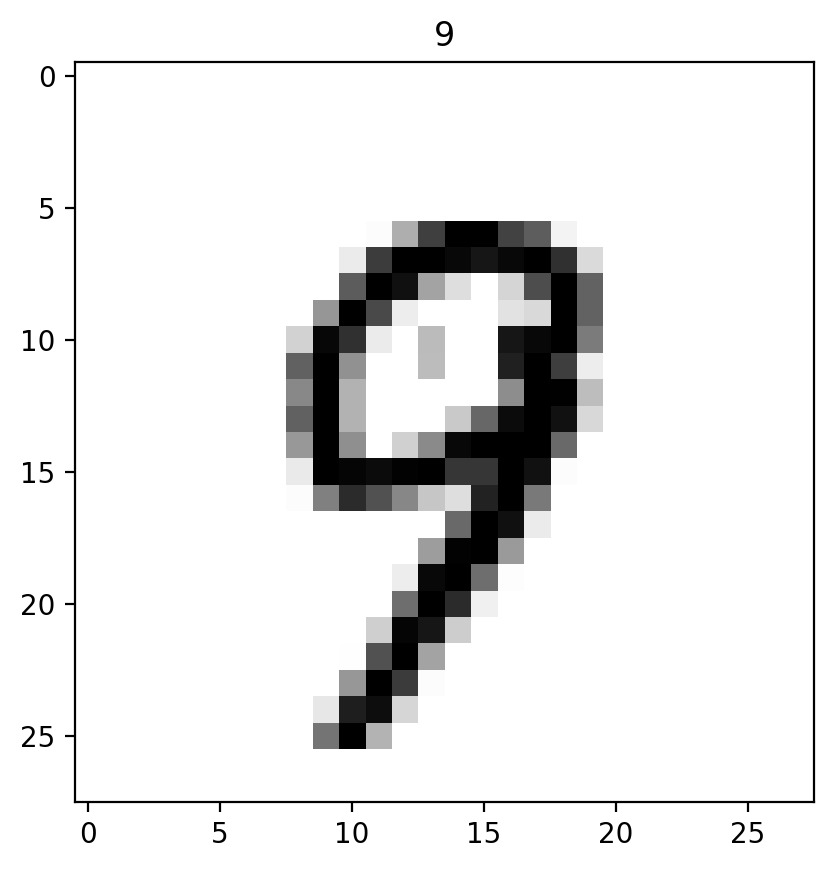

In [108]:
# Forward pass through the model



saved_img, saved_target = next(iter(train_loader))
plt.imshow(saved_img[0].numpy().squeeze(), cmap='gray_r')
plt.title(saved_target[0].item())
saved_img = saved_img.view(saved_img.shape[0], -1)
print(saved_img.shape)



out = model(saved_img)
print(out)

# Softmax
probas = F.softmax(out, dim=1)
print(probas)

In [109]:
# Predicted label before training

pred = torch.argmax(probas, dim=1)
print(f"Prediction:  {pred.item()}, True label: {saved_target.item()}")

Prediction:  1, True label: 9


In [110]:
model.fc1.weight.shape, model.fc1.bias.shape

(torch.Size([64, 784]), torch.Size([64]))

In [111]:
# Number of parameters in fc1
print("fc1", model.fc1.weight.numel() + model.fc1.bias.numel())

# Number of parameters in fc2
print("fc2", model.fc2.weight.numel() + model.fc2.bias.numel())

# Number of parameters in fc3
print("fc3", model.fc3.weight.numel() + model.fc3.bias.numel())

fc1 50240
fc2 2080
fc3 330


In [112]:
# Forward pass through the model and writing to tensorboard

lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

num_epochs = 1
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Reshape data to input to the network
        data = data.view(data.shape[0], -1)
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Write to tensorboard
        writer.add_scalar('training loss',
                        loss.item(),
                        epoch * len(train_loader) + batch_idx)
        
        if batch_idx % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

Epoch [1/1], Step [0/5000], Loss: 2.1845
Epoch [1/1], Step [100/5000], Loss: 2.8347
Epoch [1/1], Step [200/5000], Loss: 0.6997
Epoch [1/1], Step [300/5000], Loss: 0.0475
Epoch [1/1], Step [400/5000], Loss: 1.5400
Epoch [1/1], Step [500/5000], Loss: 0.2140
Epoch [1/1], Step [600/5000], Loss: 0.8040
Epoch [1/1], Step [700/5000], Loss: 0.0509
Epoch [1/1], Step [800/5000], Loss: 0.3949
Epoch [1/1], Step [900/5000], Loss: 0.3079
Epoch [1/1], Step [1000/5000], Loss: 0.0491
Epoch [1/1], Step [1100/5000], Loss: 0.0255
Epoch [1/1], Step [1200/5000], Loss: 0.0061
Epoch [1/1], Step [1300/5000], Loss: 0.1185
Epoch [1/1], Step [1400/5000], Loss: 0.4461
Epoch [1/1], Step [1500/5000], Loss: 0.0569
Epoch [1/1], Step [1600/5000], Loss: 0.3587
Epoch [1/1], Step [1700/5000], Loss: 0.0017
Epoch [1/1], Step [1800/5000], Loss: 0.0499
Epoch [1/1], Step [1900/5000], Loss: 0.2804
Epoch [1/1], Step [2000/5000], Loss: 0.6323
Epoch [1/1], Step [2100/5000], Loss: 3.5872
Epoch [1/1], Step [2200/5000], Loss: 0.3348


In [95]:
# Prediction on the saved image

with torch.no_grad():
    out = model(saved_img)
    probas = F.softmax(out, dim=1)
    pred = torch.argmax(probas, dim=1)
    print(pred, saved_target)

tensor([2]) tensor([2])


In [98]:
# Create a HParam dictionary for batch size and learning rate for tensorboard

b_sizes = [32, 64, 512]
lrs = [0.001, 0.01, 0.1]


num_epochs  = 1
for epoch in range(num_epochs):
    for b_size in b_sizes:
        train_loader = DataLoader(train_data, batch_size=b_size, shuffle=True)
        model = MNISTClassifier()
        for lr in lrs:
            print(f"Batch size: {b_size}, Learning rate: {lr}")
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            for batch_idx, (data, target) in enumerate(train_loader):
                # Reshape data to input to the network
                data = data.view(data.shape[0], -1)
                # Forward pass
                output = model(data)
                loss = criterion(output, target)
                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                

                # Write loss as scalar to Tensorboard and hyperparameters to HParams
                writer.add_scalar('training loss',
                                loss.item(),
                                epoch * len(train_loader) + batch_idx)
                writer.add_hparams({'lr': lr, 'bsize': b_size},
                                { 'hparam/loss': loss.item()})
                

    

Batch size: 32, Learning rate: 0.001
Batch size: 32, Learning rate: 0.01
Batch size: 32, Learning rate: 0.1
Batch size: 64, Learning rate: 0.001
Batch size: 64, Learning rate: 0.01
Batch size: 64, Learning rate: 0.1
Batch size: 512, Learning rate: 0.001
Batch size: 512, Learning rate: 0.01
Batch size: 512, Learning rate: 0.1
